#Dataset Exploration & Finetuning

In this notebook, we explore the Grade School Math dataset and prepare it for fine-tuning our language model Olmo-1B. The goal is to teach Olmo to generate elementary-level math problems. This project has mainly the goal to demonstrate the practical application of LoRA (Low-Rank Adaptation) fine-tuning technique.  

# Dataset Overview
The Grade School Math dataset -[link](https://github.com/openai/grade-school-math), created by OpenAI, contains elementary-level math problems with detailed solutions. We'll focus on the problem generation aspect, using only the question portions of the data for our fine-tuning task.

First, let's load and examine the data:

In [1]:
# Get the dataset
!wget https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/train.jsonl
!wget https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/test.jsonl

--2024-12-23 14:03:13--  https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/train.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4166206 (4.0M) [text/plain]
Saving to: ‘train.jsonl’

train.jsonl         100%[===================>]   3.97M  --.-KB/s    in 0.01s   

2024-12-23 14:03:14 (283 MB/s) - ‘train.jsonl’ saved [4166206/4166206]

--2024-12-23 14:03:14--  https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/test.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

In [2]:
import json
from typing import List, Dict

def load_jsonl(file_path: str) -> List[Dict]:
    """Load data from a jsonl file."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Load training and test data
train_data = load_jsonl('train.jsonl')
test_data = load_jsonl('test.jsonl')

print(f"Training examples: {len(train_data)}")
print(f"Test examples: {len(test_data)}")

# Display a few examples
print("\nExample problems:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(train_data[i]['question'])

Training examples: 7473
Test examples: 1319

Example problems:

Example 1:
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

Example 2:
Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?

Example 3:
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?


Let's analyze key characteristics of our dataset:

In [3]:
def analyze_problems(data: List[Dict]) -> Dict:
    """Analyze characteristics of math problems."""
    analysis = {
        'lengths': [],
        'word_counts': [],
        'number_counts': [],
    }

    for item in data:
        text = item['question']
        analysis['lengths'].append(len(text))
        analysis['word_counts'].append(len(text.split()))
        analysis['number_counts'].append(sum(c.isdigit() for c in text))

    return analysis

# Perform analysis on the training set
train_analysis = analyze_problems(train_data)

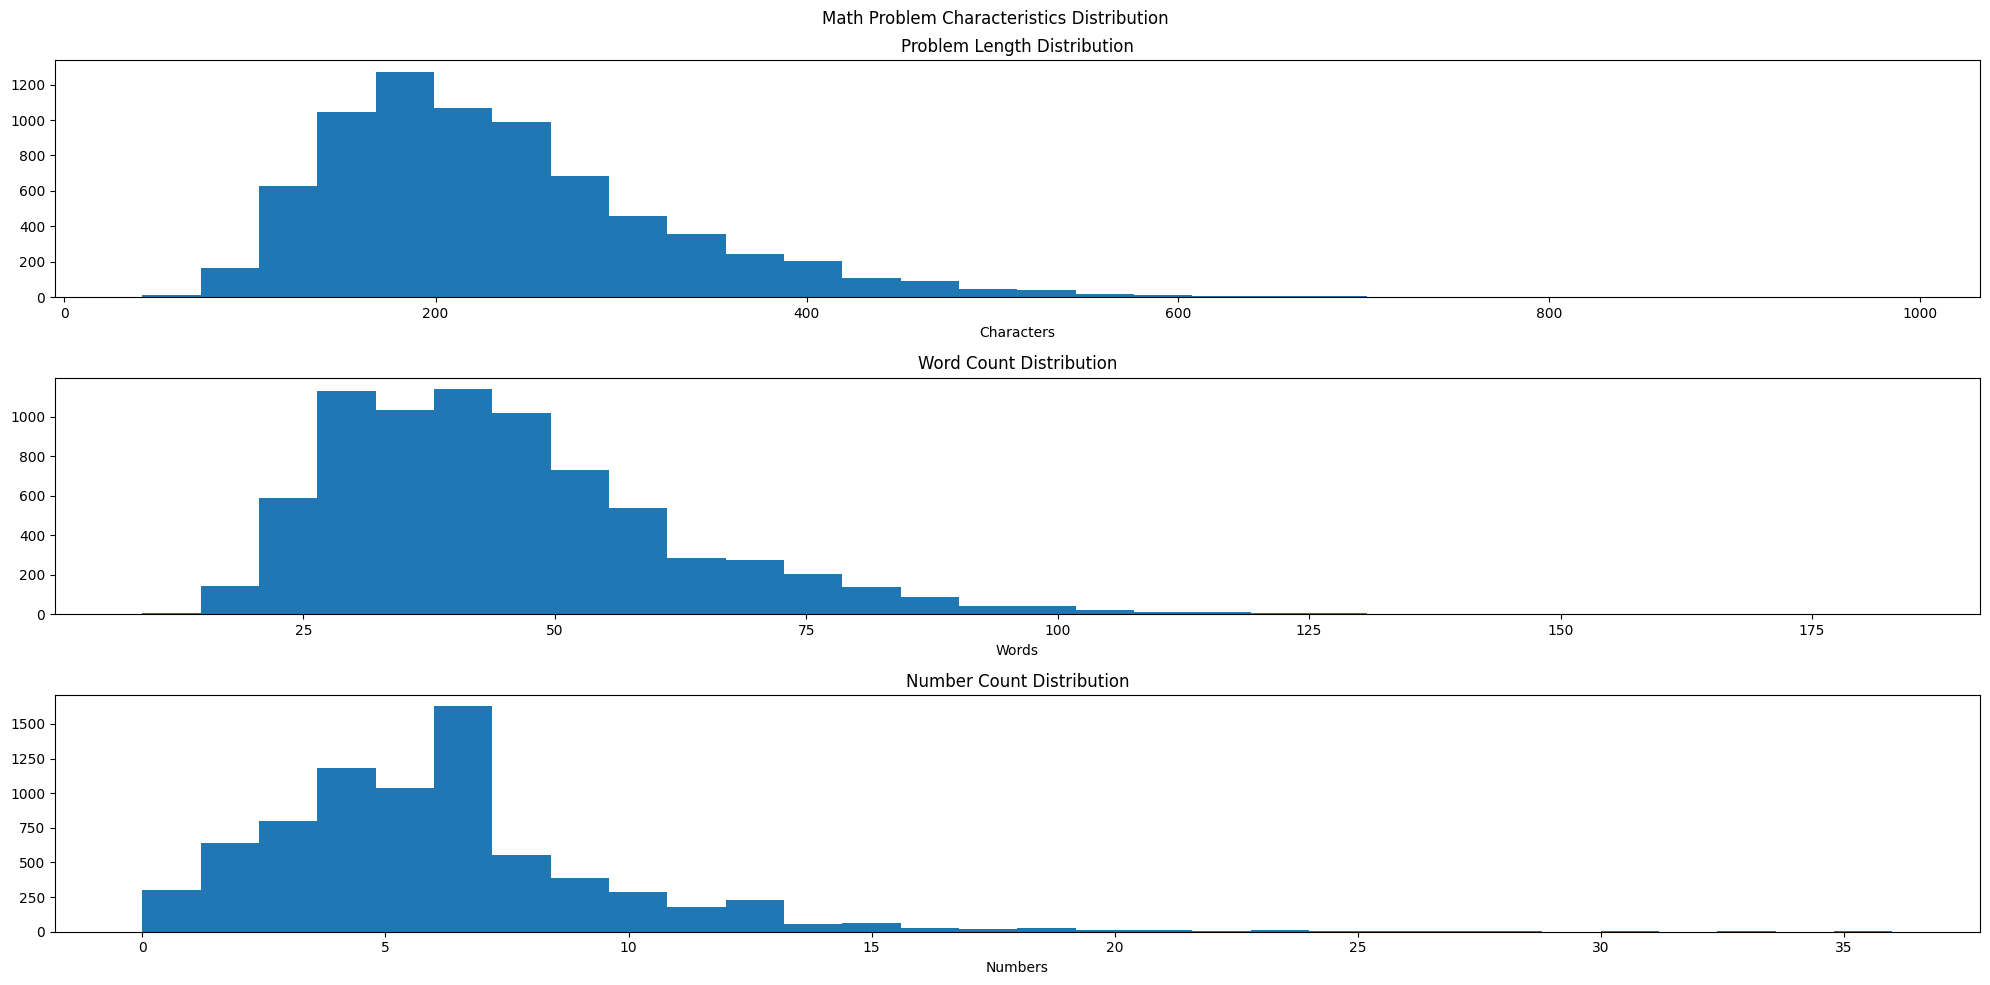

In [10]:
import matplotlib.pyplot as plt

# Plot distributions
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
fig.suptitle('Math Problem Characteristics Distribution')

axes[0].hist(train_analysis['lengths'], bins=30)
axes[0].set_title('Problem Length Distribution')
axes[0].set_xlabel('Characters')

axes[1].hist(train_analysis['word_counts'], bins=30)
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Words')

axes[2].hist(train_analysis['number_counts'], bins=30)
axes[2].set_title('Number Count Distribution')
axes[2].set_xlabel('Numbers')

plt.tight_layout()
plt.show()

# Dataset Preparation

now we need to prepare the dataset for finetuning.

we start from implementing a MathProblemDataset class This implementation:

* Reads the JSONL file line by line
* Parses each line as JSON
* Extracts just the 'question' field since we only want to learn to generate problems, not solutions
* Provides standard Dataset interface methods len and getitem

In [22]:
!pip install -q peft transformers datasets einops evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.3 MB/s eta 0:00:00


In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
class MathProblemDataset(Dataset):
    def __init__(self, dataset_path):
        """Initialize dataset from JSONL file.

        Args:
            dataset_path: Path to JSONL file containing math problems
        """
        self.problems = []

        # Read and parse JSONL file
        with open(dataset_path, 'r', encoding='utf-8') as f:
            for line in f:
                problem = json.loads(line)
                # We only want the question part, not the solution
                self.problems.append(problem['question'])

    def __len__(self):
        """Return number of problems in dataset."""
        return len(self.problems)

    def __getitem__(self, idx):
        """Get problem at given index.

        Args:
            idx: Index of problem to retrieve

        Returns:
            String containing the math problem
        """
        return self.problems[idx]

In [21]:
# Create train and test datasets
train_dataset = MathProblemDataset("train.jsonl")
test_dataset = MathProblemDataset("test.jsonl")

print(f"Training examples: {len(train_dataset)}")
print(f"Test examples: {len(test_dataset)}")
print("\nSample problems:\n")
print("Train samples")
print(*train_dataset[:5], sep='\n')
print("Test samples")
print(*test_dataset[:5], sep="\n")

Training examples: 7473
Test examples: 1319

Sample problems:

Train samples
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?
Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?
James writes a 3-page letter to 2 different friends twice a week.  How many pages does he write a year?
Test samples
Janet’s ducks lay 16 eggs per day. She eats three for b

## Model Setup

Now we'll initialize our base model (OLMo-1B) and its tokenizer:

In [24]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

def setup_base_model():
    """Initialize the base model and tokenizer."""
    model_name = "allenai/OLMo-1B-hf"

    # Load tokenizer and model with progress bars
    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')

    print("Loading model...")
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",  # Automatically handle device placement
        torch_dtype=torch.float16  # Use fp16 for efficiency
    )

    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id

    return model, tokenizer

# Clear GPU memory if needed
import gc
gc.collect()
torch.cuda.empty_cache()

# Load model
model, tokenizer = setup_base_model()

Loading tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Loading model...


config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.71G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

## Generation Function

Let's implement a function to generate math problems using our model:

In [26]:
from typing import List
from transformers import PreTrainedModel

def generate_math_problem(
        prefix: List[str],
        model: PreTrainedModel,
        device: str = 'cuda',
        max_generated_tokens: int = 50
    ):
    """Generate math problems from given prefixes.

    Args:
        prefix: List of prefix strings to start generation from
        model: The language model to use for generation
        device: Device to run generation on
        max_generated_tokens: Maximum number of tokens to generate
    """
    # Ensure model is on correct device
    model = model.to(device)

    # Tokenize prefixes
    inputs = tokenizer(prefix, return_tensors="pt", padding=True).to(device)

    # Generate with nucleus sampling
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_generated_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [27]:
# Generates some examples to test our function and get a feeling for model performance with this task
from IPython.display import display

model = model.cuda()

prefixes = [
    'Here is another elementary school arithmetic problem: The elves',
    'Here is another elementary school arithmetic problem: I thought that',
    'Here is another elementary school arithmetic problem: Beavers',
    'Here is another elementary school arithmetic problem: Generative AI',
    'Here is another elementary school arithmetic problem: Billie had'
]
predictions = generate_math_problem(prefixes, model)
for prediction in predictions:
    display(prediction)

'Here is another elementary school arithmetic problem: The elves are busy wrapping presents for the Christmas holiday. You have $1,000 in gift cards to spend. How many gift cards will you need to buy $100 worth of presents?\nYou can solve this problem by taking the number of gift cards you'

"Here is another elementary school arithmetic problem: I thought that you were going to take a closer look at this one. The answer is: yes. The problem is, you don't know what the number is.\nThis is an important mathematical fact. The number that you see on the page is not the"

'Here is another elementary school arithmetic problem: Beavers are eating the leaves of a tree.\nHow many leaves do Beavers eat?\nHow many Beavers eat the leaves of a tree?\nHow many Beavers eat the leaves of a tree?\nHow many Beavers eat the leaves of'

'Here is another elementary school arithmetic problem: Generative AI is a tool that can be used to create computer programs that solve problems. That means that it can be used to create algorithms for generating art, for generating music, for generating language.\nIt’s an amazing tool. It’s also an'

'Here is another elementary school arithmetic problem: Billie had four apples. Billie and her friend, Susan, had two apples each. How many apples did they each have?\nI’ve always had a problem with this problem. I don’t know why. I think it’s because of'

In [28]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install peft --quiet

## Data Preprocessing for Training

The core of preparing data for language model fine-tuning:

In [30]:
def preprocess_batch(samples_batch, prefix, tokenizer, device='cuda'):
    """Prepare batch of samples for training.

    This function handles the complex requirements of language model training:
    - Combines prefix with actual content
    - Creates attention masks
    - Properly formats labels by masking prefix tokens

    Args:
        samples_batch: Batch of math problems
        prefix: Prefix to add before each problem
        tokenizer: Tokenizer to use
        device: Device to place tensors on
    """
    # Combine prefix with problems
    full_texts = [prefix + problem for problem in samples_batch]

    # Tokenize
    encoded = tokenizer(
        full_texts,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']

    # Create labels - crucial for training
    labels = input_ids.clone()

    # Find prefix length
    prefix_tokens = tokenizer(prefix, return_tensors="pt")['input_ids'][0]
    prefix_len = len(prefix_tokens)

    # Mask prefix tokens in labels
    labels[:, :prefix_len] = -100

    # Move to device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

## LoRA Configuration and Training Setup

Now we'll configure LoRA and prepare for training:


In [31]:
from peft import (
    get_peft_model,
    LoraConfig,
)

peft_config = LoraConfig(
    r=32,                     # Rank of update matrices
    lora_alpha=32,           # Alpha parameter for LoRA scaling
    target_modules='all-linear',
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

In [32]:
# Wrap model with LoRA
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Training parameters
lr = 1e-5
num_epochs = 2
batch_size = 4

trainable params: 24,117,248 || all params: 1,200,881,664 || trainable%: 2.0083


In [33]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [34]:
from transformers import get_linear_schedule_with_warmup

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [35]:
from tqdm import tqdm

PREFIX="Here's another elementary school math problem: "

model = model.cuda()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        model_inputs = preprocess_batch(batch, prefix=PREFIX, tokenizer=tokenizer)
        outputs = model(**model_inputs)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(test_dataloader)):
        model_inputs = preprocess_batch(batch, prefix=PREFIX, tokenizer=tokenizer)
        with torch.no_grad():
            outputs = model(**model_inputs)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(
                torch.argmax(outputs.logits, -1).detach().cpu().numpy(),
                skip_special_tokens=True
            )
        )

    eval_epoch_loss = eval_loss / len(test_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}:\n{train_ppl=}\n{train_epoch_loss=}\n{eval_ppl=}\n{eval_epoch_loss=}")


100%|██████████| 330/330 [00:29<00:00, 11.15it/s]


epoch=0:
train_ppl=tensor(4.8042, device='cuda:0')
train_epoch_loss=tensor(1.5695, device='cuda:0')
eval_ppl=tensor(4.4521, device='cuda:0')
eval_epoch_loss=tensor(1.4934, device='cuda:0')


100%|██████████| 330/330 [00:29<00:00, 11.16it/s]

epoch=1:
train_ppl=tensor(4.3533, device='cuda:0')
train_epoch_loss=tensor(1.4709, device='cuda:0')
eval_ppl=tensor(4.3933, device='cuda:0')
eval_epoch_loss=tensor(1.4801, device='cuda:0')


In [36]:
model = model.cuda()

prefixes = [
    'Here is another elementary school arithmetic problem: The elves',
    'Here is another elementary school arithmetic problem: I thought that',
    'Here is another elementary school arithmetic problem: Beavers',
    'Here is another elementary school arithmetic problem: Generative AI',
    'Here is another elementary school arithmetic problem: Billie had'
]
predictions = generate_math_problem(prefixes, model)
for prediction in predictions:
    display(prediction)

'Here is another elementary school arithmetic problem: The elves can make 5 ornaments each day. They make 3 ornaments on Monday, 2 on Tuesday and 1 on Wednesday. How many ornaments did the elves make in total? If the elves made 3 ornaments on Tuesday, calculate the total'

'Here is another elementary school arithmetic problem: I thought that my friend could run 5 kilometers per hour. If she runs at 6 kilometers per hour, how many minutes will it take her to run 5 kilometers? If she runs at 4 kilometers per hour, how many minutes will it take her to run 6 kilometers'

'Here is another elementary school arithmetic problem: Beavers can run at a speed of 15 miles per hour. If Beavers can run 30 miles in a day, how many Beavers can Beavers can run in 10 days?\nIn the first day, Beavers can run 15 miles.\nIn'

'Here is another elementary school arithmetic problem: Generative AI will be able to make a sculpture out of a list of objects. If it can make 2 sculptures from a list of 20 objects, how many objects does it need to make a sculpture from?\nThe first sculpture is a sculpture of a circle,'

'Here is another elementary school arithmetic problem: Billie had $2,000. Billie decided to save half of this amount. How much money did Billie save? Billie decided to spend $500 on a new pair of shoes. How much money did Billie spend on the shoes? Billie'

In [37]:
# save the fine-tuned model
model.save_pretrained("math_finetune")

In [46]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
# Save finetuned model to a folder in my Drive
model.save_pretrained("/content/drive/MyDrive/Courses & Learning/Nebius Academy/Practical Gen AI /Week 4 - Fine-tuning")

Now let's evaluate the old model non-finetuned on the same prefix input to get a grasp of the improvements

In [42]:
 # Load a fresh copy of the base model
base_model, _ = setup_base_model()

Loading tokenizer...
Loading model...


In [44]:
print("Generating with base model:")
base_outputs = generate_math_problem(prefixes, base_model)
for output in base_outputs:
    print(f"\n{output}")

Generating with base model:

Here is another elementary school arithmetic problem: The elves have to help the children of the school learn their addition facts. How can they do that? They can’t just sit on the teacher’s shoulder and tell her the answers. The children will not be able to learn.
The same is

Here is another elementary school arithmetic problem: I thought that I had a lot of money in my savings account, but I didn’t. That’s because I had just bought a house, and I was saving up for a down payment. So I told my accountant that I had a lot of money

Here is another elementary school arithmetic problem: Beavers have a total of 24 teeth. If each tooth has a length of 2.5 cm, how many teeth does each beaver have?
The answer is 12.
If you had a square root of 24, the answer would be 12.

Here is another elementary school arithmetic problem: Generative AI. The problem is this: How do you know if a given sequence of numbers is a number? The answer is that we don't.
Generative AI 